# Pretty plots

This notebook loads raw data, does the grouping / averaging / etc and produces the publication-ready plots in 2 column version. The plots are essentially the same as the one column version, but are placed into subplots, with the figure size (190 mm width) and font sizes set to match the desired print size. Additionally, the dataframe operations are piped to make them more concise.

In [1]:
import os
import pandas
import seaborn
import matplotlib.pyplot as plt

In [2]:
import configparser
config = configparser.ConfigParser()
config.read('emocon_config.ini')
BEHAV_DIR = config['DEFAULT']['BEHAV_DIR']

In [3]:
# this may be helpful
def replace_xticklabels(ax, rep_dict):
    labels = [xtl.get_text() for xtl in ax.get_xticklabels()]
    new_labels = []
    for old_text in labels:
        if old_text in rep_dict:
            new_labels.append(rep_dict[old_text])
        else:
            new_labels.append(old_text)
    ax.set_xticklabels(new_labels)

In [4]:
my_rcparams = {
    'figure.figsize': (7.48, 3.),  # 7.48 in = 190 mm, two-column width by elsevier standards
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.size': 10,
#    'figure.autolayout': True,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'legend.fontsize': 7,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
}

In [5]:
seaborn.set(style='white', rc=my_rcparams)

## EMG

In [6]:
data_path = os.path.join('out', 'stat_data', 'emg.pickle')
emg = pandas.read_pickle(data_path)

In [7]:
contingency = pandas.read_csv(os.path.join(BEHAV_DIR, 'contingency.csv'),
                              index_col=0)
contingency.contingency_known = contingency.contingency_known.astype(bool)

Within-subject mean amplitudes, short-form dataframe

In [8]:
emg_mean = (emg
            .groupby(['code',  'stimulus'])
            .amplitude
            .mean()
            .unstack()
            .join(contingency, how='left')
           )

In [9]:
emg_mean.head()

,direct CS+,direct CS-,direct fix,obs CS+,obs CS-,obs fix,contingency_known
code,,,,,,,
BDKNVC,53.122290,57.948134,48.449187,50.861772,48.027018,46.351405,False
BKIXTF,51.632845,54.736945,57.637755,49.821544,48.181192,44.993491,False
CCCFRT,50.682422,54.946818,44.735609,51.042654,50.191199,48.583723,False
DLYXKI,53.590286,48.657150,55.564094,48.526125,47.086128,50.481982,False
DXIJNB,52.858753,51.811504,46.927188,50.506385,50.416151,48.278742,False


In [10]:
emg_mean.shape

(32, 7)

Convert the above to long-form for seaborn plots using hue

In [11]:
emg_melted = (emg_mean
              .reset_index()
              .melt(
                  id_vars=['code', 'contingency_known'],
                  var_name='stimulus',
                  value_name='amplitude')
             )

In [12]:
emg_melted.head()

,code,contingency_known,stimulus,amplitude
0,BDKNVC,False,direct CS+,53.122290
1,BKIXTF,False,direct CS+,51.632845
2,CCCFRT,False,direct CS+,50.682422
3,DLYXKI,False,direct CS+,53.590286
4,DXIJNB,False,direct CS+,52.858753


In [13]:
my_order = ['obs CS+', 'obs CS-', 'obs fix', 'direct CS+', 'direct CS-', 'direct fix']

In [14]:
pal_1 = seaborn.color_palette(['steelblue', 'gold', 'lightgray'])

7.48 3.0


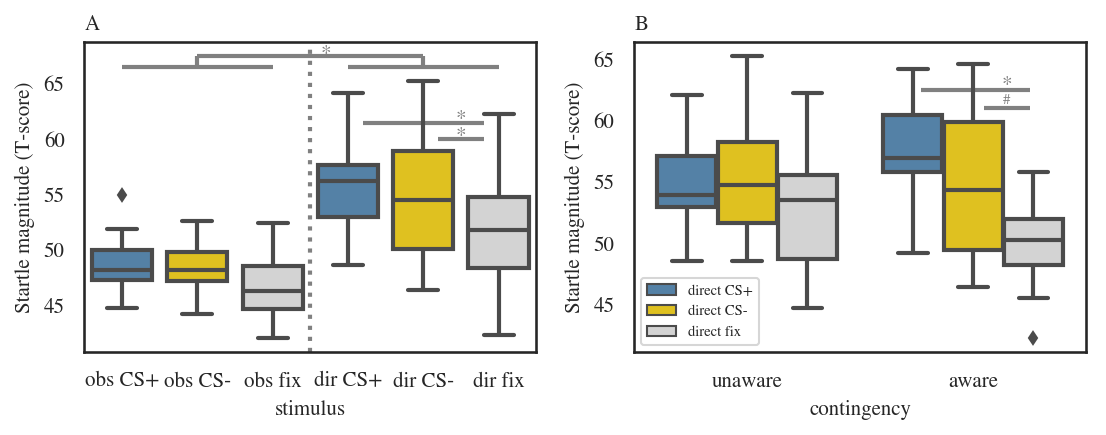

In [15]:
fig = plt.figure(dpi=150)
ax1 = plt.subplot2grid((1,2), (0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

# Plot the first boxplot
seaborn.boxplot(ax=ax1, data=emg_mean, order=my_order, palette = pal_1, fliersize=4)
ax1.set_ylabel('Startle magnitude (T-score)')
ax1.axvline(2.5, color='gray', ls=':')
ax1.set_title('A', loc='left')

replace_xticklabels(ax1, {'direct CS+': 'dir CS+', 'direct CS-': 'dir CS-', 'direct fix': 'dir fix'})

# Draw the brace
ax1.hlines(67.5, 1, 4, color='gray')
ax1.hlines([66.5, 66.5], [0, 3], [2, 5], color='gray')
ax1.vlines([1, 4], 66.5, 67.5, color='gray')
ax1.text(2.7, 67.5-0.2, '*', horizontalalignment='center', color='gray', fontsize=10)

# Draw the lines
ax1.hlines(60, 4.2, 4.8, color='gray')
ax1.text(4.5, 60-0.15, '*', horizontalalignment='center', color='gray', fontsize=10)
ax1.hlines(61.5, 3.2, 4.8, color='gray')
ax1.text(4.5, 61.5-0.15, '*', horizontalalignment='center', color='gray', fontsize=10)
ax1.set_xlabel('stimulus')


# Plot the second boxplot
seaborn.boxplot(ax=ax2,
                data=emg_melted.query('stimulus.str.startswith("direct")'),
                x='contingency_known', y='amplitude', hue='stimulus',
                palette=pal_1, fliersize=4,
               )
ax2.set_xlabel('contingency')
ax2.set_ylabel('Startle magnitude (T-score)')
ax2.set_title('B', loc='left')
replace_xticklabels(ax2, {'True': 'aware', 'False': 'unaware'})

# Draw the lines
ax2.hlines(61, 1.05, 1.25, color='gray')
ax2.text(1.15, 61.1, '#', horizontalalignment='center', verticalalignment='bottom', color='gray', fontsize=7)
ax2.hlines(62.5, 0.77, 1.25, color='gray')
ax2.text(1.15, 62.5, '*', horizontalalignment='center', color='gray', fontsize=10)
ax2.legend(loc='lower left')

fig.tight_layout()

print(fig.get_figwidth(), fig.get_figheight())

In [16]:
if not os.path.isdir('out/figures/pub'):
    os.mkdir('out/figures/pub')
fig.savefig('out/figures/pub/startle.png')

In [17]:
#ax1.figure.savefig('/Users/michal/Desktop/plot.eps')

## EDA

In [18]:
data_path = os.path.join('out', 'stat_data', 'eda.pickle')
df = pandas.read_pickle(data_path)

In [19]:
# Replace nans with zeros
dfz = df.fillna(value=0)

In [20]:
eda_mean = (df
            .fillna(value=0)
            .groupby(['code',  'stimulus'])
            .amplitude.mean()
            .unstack()
            .join(contingency, how='left')
           )

In [21]:
eda_mean.head()

,direct CS+,direct CS-,obs CS+,obs CS-,obs US absent,obs US present,contingency_known
code,,,,,,,
BDKNVC,0.065267,0.041473,0.071568,0.037846,0.016097,0.110232,False
CCCFRT,0.059477,0.066935,0.100087,0.162599,0.093659,0.081801,False
CSSIEB,0.037792,0.161456,0.089512,0.087098,0.123457,0.253569,False
DLYXKI,0.049786,0.107779,0.008219,0.028236,0.000000,0.131711,False
DXIJNB,0.112979,0.082707,0.035466,0.023129,0.000000,0.037535,False


In [22]:
eda_melted = (eda_mean
              .reset_index()
              .melt(
                  id_vars=['code', 'contingency_known'],
                  var_name='stimulus',
                  value_name='amplitude')
             )
eda_melted.head()

,code,contingency_known,stimulus,amplitude
0,BDKNVC,False,direct CS+,0.065267
1,CCCFRT,False,direct CS+,0.059477
2,CSSIEB,False,direct CS+,0.037792
3,DLYXKI,False,direct CS+,0.049786
4,DXIJNB,False,direct CS+,0.112979


In [23]:
my_order_eda = ['obs CS+', 'obs CS-', 'obs US present', 'obs US absent', 'direct CS+', 'direct CS-']
pal_2 = seaborn.color_palette(['steelblue', 'gold'])
pal_3 = seaborn.color_palette([(196/255, 46/255, 74/255), (61/255, 125/255, 90/255)], desat=1)
pal_combined = pal_2 + pal_3 + pal_2

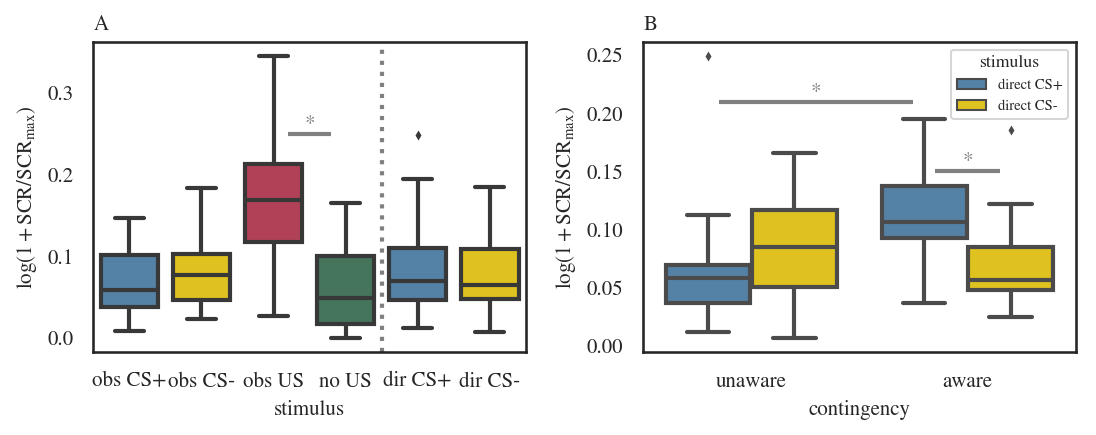

In [24]:
fig2 = plt.figure(dpi=150)

ax3 = plt.subplot2grid((1,2), (0,0), colspan=1)
ax4 = plt.subplot2grid((1,2), (0,1), colspan=1)

# First boxplot
seaborn.boxplot(ax=ax3, data=eda_mean, order=my_order_eda, palette=pal_combined, fliersize=2)
ax3.axvline(3.5, color='gray', ls=':')
ax3.set_ylabel('Mean magnitude')
ax3.set_title('A', loc='left')

replace_xticklabels(ax3, {'direct CS+': 'dir CS+', 'direct CS-': 'dir CS-',
                         'obs US present': 'obs US', 'obs US absent': 'no US'})
#plt.setp(ax3.get_xticklabels(), rotation=30)
ax3.set_xlabel('stimulus')
ax3.set_ylabel('$\log(1 + \mathrm{SCR/SCR_{max}})$')

# Draw the line
ax3.hlines(0.25, 2.2, 2.8, color='gray')
ax3.text(2.5, 0.25, '*', horizontalalignment='center', verticalalignment='bottom', color='gray', fontsize=10)


# Second boxplot
seaborn.boxplot(ax=ax4,
                data=eda_melted.query('stimulus.str.startswith("direct")'),
                x='contingency_known', y='amplitude', hue='stimulus',
                palette=pal_2, fliersize=2,
               )
ax4.set_xlabel('contingency')
ax4.set_ylabel('$\log(1 + \mathrm{SCR/SCR_{max}})$')
ax4.set_title('B', loc='left')
replace_xticklabels(ax4, {'True': 'aware', 'False': 'unaware'})

# Draw the lines
ax4.hlines(0.21, -0.15, 0.75, color='gray')
ax4.text(0.3, 0.21, '*', horizontalalignment='center', verticalalignment='bottom', color='gray', fontsize=10)
ax4.hlines(0.15, 0.85, 1.15, color='gray')
ax4.text(1, 0.15, '*', horizontalalignment='center', verticalalignment='bottom', color='gray', fontsize=10)

fig2.tight_layout()

In [25]:
fig2.savefig('out/figures/pub/eda.png')